## Oxparis Visualization Notebook
In this notebook one can load images and gt from the oxparis dataset as given by the POLD2 team (they were givin it by remi).
Possible actions in this Notebook:
- Load Images from the dataset and look at it and GT
- Run model on image and compare result with gt
- also detect lines

In [1]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
from gluefactory.datasets import get_dataset

line_neighborhood = 5 # in px used to normalize/ denormalize df

Define utility functions

In [2]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def normalize_df(df):
    return -torch.log(df / line_neighborhood + 1e-6)

def denormalize_df(df_norm):
    return torch.exp(-df_norm) * line_neighborhood

def visualize_img_with_gt(dset, num=5, offset=0, lim_kpoints=-1):
    idxs = list(range(offset, offset+num, 1))
    _, ax = plt.subplots(len(idxs), 4, figsize=(20, num*4))
    for i in idxs:
        elem = dset[i]
        
        af = elem["deeplsd_angle_field"]
        df = elem["deeplsd_distance_field"]
        hmap = elem["superpoint_heatmap"]
        orig_pt = elem["gt_keypoints"]
        
        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Heatmap ({hmap.shape})')
        ax[i, 0].imshow(hmap)

        ax[i, 1].axis('off')
        ax[i, 1].set_title('Distance Field')
        ax[i, 1].imshow(df)

        ax[i, 2].axis('off')
        ax[i, 2].set_title('Angle Field')
        ax[i, 2].imshow(get_flow_vis(df, af))

        ax[i, 3].axis('off')
        ax[i, 3].set_title('Original')
        ax[i, 3].imshow(elem["image"].permute(1,2,0))
        ax[i, 3].scatter(orig_pt[:lim_kpoints, 0], orig_pt[:lim_kpoints, 1], marker="o", color="red", s=3)
    plt.show()
    

In [4]:
dset_conf = {
            "train_batch_size": 2,
            "reshape": 800,  # ex. 800
            "square_pad": False, # pads the image to be in square format(only if reshape is activated). useful for batching together images with reshape in training
            "multiscale_learning": {
                "do": False,
                "scales_list": [800, 600, 400],
                "scale_selection": 'round-robin' # random or round-robin
            },
            "load_features": {
                "do": True,
                "check_exists": True,
                "point_gt": {
                    "data_keys": ["superpoint_heatmap", "gt_keypoints", "gt_keypoints_scores"],
                    "use_score_heatmap": False,
                    "max_num_keypoints": None, # load all kp
                    "use_deeplsd_lineendpoints_as_kp_gt": True,  # set true to use deep-lsd line endpoints as keypoint groundtruth
                    "use_superpoint_kp_gt": True  # set true to use default HA-Superpoint groundtruth
                },
                "line_gt": {
                    "data_keys": ["deeplsd_distance_field", "deeplsd_angle_field"],
                    "enforce_threshold": 5.0,  # Enforce values in distance field to be no greater than this value
                },
            },
        }#oxford_paris_mini_1view_jpldd
loaded_ds = get_dataset("minidepth")(dset_conf)
ds = loaded_ds.get_dataset(split="val")

# load one test element
elem = ds[0]
print(elem['name'])
print(f"Img-Shape: {elem['image'].shape}")
print(f"Keys: {elem.keys()}")

# print example shapes
af = elem["deeplsd_angle_field"]
df = elem["deeplsd_distance_field"]
hmap = elem["superpoint_heatmap"]
gt_kpt = elem["gt_keypoints"]
gt_kp_scores = elem["gt_keypoints_scores"]

print(f"AF: type: {type(af)}, shape: {af.shape}, min: {torch.min(af)}, max: {torch.max(af)}")
print(f"DF: type: {type(df)}, shape: {df.shape}, min: {torch.min(df)}, max: {torch.max(df)}")
print(f"Keypoints: #{gt_kpt.shape[0]}")
print(f"KP-HMAP: type: {type(hmap)}, shape: {hmap.shape}, min: {torch.min(hmap)}, max: {torch.max(hmap)}, sum: {torch.sum(hmap)}")

[11/10/2024 22:32:39 gluefactory.datasets.base_dataset INFO] Creating dataset MiniDepthDataset
[11/10/2024 22:32:39 gluefactory.datasets.minidepth INFO] NUMBER OF IMAGES: 850
[11/10/2024 22:32:40 gluefactory.datasets.minidepth INFO] NUMBER OF IMAGES WITH GT: 850


0015/3772586642_ef60d44ac2_o.jpg
Img-Shape: torch.Size([3, 523, 800])
Keys: dict_keys(['name', 'scales', 'image_size', 'transform', 'original_image_size', 'image', 'deeplsd_distance_field', 'deeplsd_angle_field', 'superpoint_heatmap', 'gt_keypoints', 'gt_keypoints_scores'])
AF: type: <class 'torch.Tensor'>, shape: torch.Size([523, 800]), min: 0.0015061409212648869, max: 3.140437364578247
DF: type: <class 'torch.Tensor'>, shape: torch.Size([523, 800]), min: 0.5322995185852051, max: 4.999999523162842
Keypoints: #3968
KP-HMAP: type: <class 'torch.Tensor'>, shape: torch.Size([523, 800]), min: 0.0, max: 1.0, sum: 3749.0


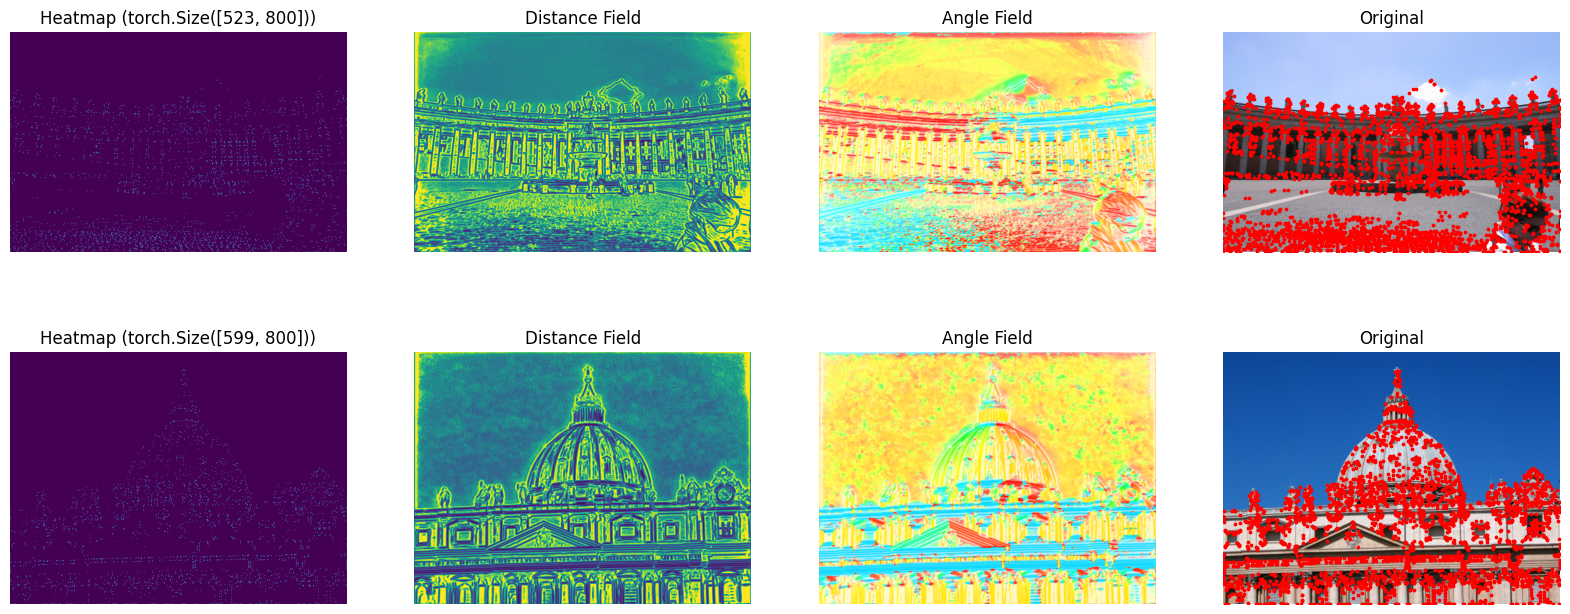

In [5]:
visualize_img_with_gt(ds, num=2)

## Run a model to get predictions

Define utility for visualisation and example calculation

In [6]:
def compute_and_visualize(img_data_with_gt, model, device, visualize=False):
    img_torch = img_data_with_gt["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = model({"image": img_torch})
    jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0].cpu()
    jpldd_af = output_model['line_anglefield'][0].cpu()
    jpldd_df = output_model['line_distancefield'][0].cpu()
    jpldd_kp = output_model['keypoints'][0].cpu()
        
    af_gt = img_data_with_gt["deeplsd_angle_field"].cpu()
    df_gt = img_data_with_gt["deeplsd_distance_field"].cpu()
    hmap_gt = img_data_with_gt["superpoint_heatmap"].cpu()
    orig_pt_gt = img_data_with_gt["gt_keypoints"].cpu()
    print(f"Num GT-KP: {orig_pt_gt.shape[0]}")
    
    if visualize:
        _, ax = plt.subplots(2, 4, figsize=(20, 8))
        ax[0, 0].axis('off')
        ax[0, 0].set_title('GT-Heatmap')
        ax[0, 0].imshow(hmap_gt)

        ax[0, 1].axis('off')
        ax[0, 1].set_title('GT-Distance Field')
        ax[0, 1].imshow(df_gt)

        ax[0, 2].axis('off')
        ax[0, 2].set_title('GT-Angle Field')
        ax[0, 2].imshow(get_flow_vis(df_gt, af_gt))

        ax[0, 3].axis('off')
        ax[0, 3].set_title('GT-Keypoints')
        ax[0, 3].imshow(img_data_with_gt["image"].permute(1,2,0))
        ax[0, 3].scatter(orig_pt_gt[:, 0], orig_pt_gt[:, 1], marker="o", color="red", s=3)
        
        ax[1, 0].axis('off')
        ax[1, 0].set_title('KP&J Heatmap')
        ax[1, 0].imshow(jpldd_kpjhm)

        ax[1, 1].axis('off')
        ax[1, 1].set_title('Distance Field')
        ax[1, 1].imshow(jpldd_df)

        ax[1, 2].axis('off')
        ax[1, 2].set_title('Angle Field')
        ax[1, 2].imshow(get_flow_vis(jpldd_df, jpldd_af))

        ax[1, 3].axis('off')
        ax[1, 3].set_title('Detected kp')
        ax[1, 3].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
        ax[1, 3].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)
        plt.show()
    return output_model

In [7]:
from gluefactory.models import get_model

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Device Used: {device}")

jpl_conf1 = {
    "name": "joint_point_line_extractor",
    "max_num_keypoints": 1500,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": True,
        "conf": {
            "num_sample": 8,
            "num_sample_strong": 150,
            "max_point_size": 1500,

        "distance_map": {
            "threshold": 0.5,
            "avg_filter_size": 13,
            "avg_filter_padding": 6,
            "avg_filter_stride": 1,
            "max_value": 5,
            "inlier_ratio": 0.8,
            "max_accepted_mean_value": 0.4
        },

        "mlp_conf": {
            "has_angle_field": True,
            "has_distance_field": True, 
            "num_line_samples": 30,    # number of sampled points between line endpoints
            "num_bands": 3,
            "mlp_hidden_dims": [256, 128, 128, 64, 32],
            "pred_threshold": 0.9,
            "weights": "/local/home/Point-Line/outputs/training/oxparis_300lines_deeper_net_300img_deeplsd/checkpoint_best.tar",
        }
        }
    },
    "checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/oxparis_800_focal/checkpoint_best.tar"
}
jpl_model1 = get_model("joint_point_line_extractor")(jpl_conf1).to(device)
jpl_model1.eval()

Device Used: cuda


Load model parameters from checkpoint /local/home/rkreft/shared_team_folder/outputs/training/oxparis_800_focal/checkpoint_best.tar
/local/home/rkreft/glue-factory/gluefactory/models/extractors/joint_point_line_extractor.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

### Compute and visualize
Prediction and groundtruth for a given image

Num GT-KP: 4440


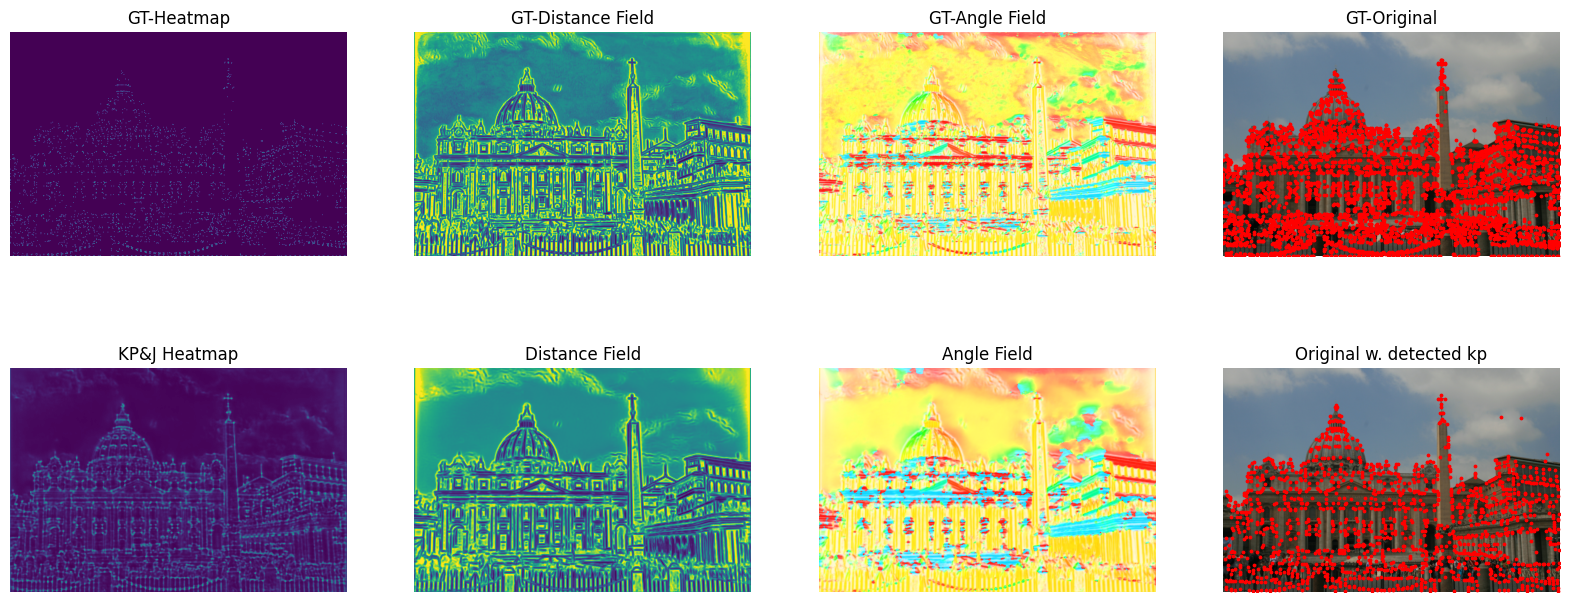

In [8]:
output_model = compute_and_visualize(ds[42], jpl_model1, device, visualize=True)

### Compare Model Versions on Oxparis

In [13]:
jpl_conf2 = {
    "name": "joint_point_line_extractor",
    "max_num_keypoints": 1500,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": True,
        "conf": {
            "num_sample": 8,
            "num_sample_strong": 150,
            "max_point_size": 1500,

        "distance_map": {
            "threshold": 0.5,
            "avg_filter_size": 13,
            "avg_filter_padding": 6,
            "avg_filter_stride": 1,
            "max_value": 5,
            "inlier_ratio": 0.8,
            "max_accepted_mean_value": 0.4
        },

        "mlp_conf": {
            "has_angle_field": True,
            "has_distance_field": True, 
            "num_line_samples": 30,    # number of sampled points between line endpoints
            "num_bands": 3,
            "mlp_hidden_dims": [256, 128, 128, 64, 32],
            "pred_threshold": 0.9,
            "weights": "/local/home/Point-Line/outputs/training/oxparis_300lines_deeper_net_300img_deeplsd/checkpoint_best.tar",
        }
        }
    },
    "checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/oxparis_800_focal_dlsd_kp/checkpoint_best.tar"
}

jpl_2 = get_model("extractors.joint_point_line_extractor")(jpl_conf2)
jpl_2.to(device)
jpl_2.eval()

Load model parameters from checkpoint /local/home/rkreft/shared_team_folder/outputs/training/oxparis_800_focal_dlsd_kp/checkpoint_best.tar
/local/home/rkreft/glue-factory/gluefactory/models/extractors/joint_point_line_extractor.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contr

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [28]:
img = 5
out_jpl_1 = compute_and_visualize(ds[img], jpl_model1, device=device, visualize=False)
out_jpl_2 = compute_and_visualize(ds[img], jpl_2, device=device, visualize=False)

df_1 = out_jpl_1['line_distancefield'][0].cpu()
df_2 = out_jpl_2['line_distancefield'][0].cpu()
diff = np.abs(df_1 - df_2)
diff_df_sum = (diff).sum()
print(diff_df_sum)

Num GT-KP: 2128
Num GT-KP: 2128
tensor(200325.4531)


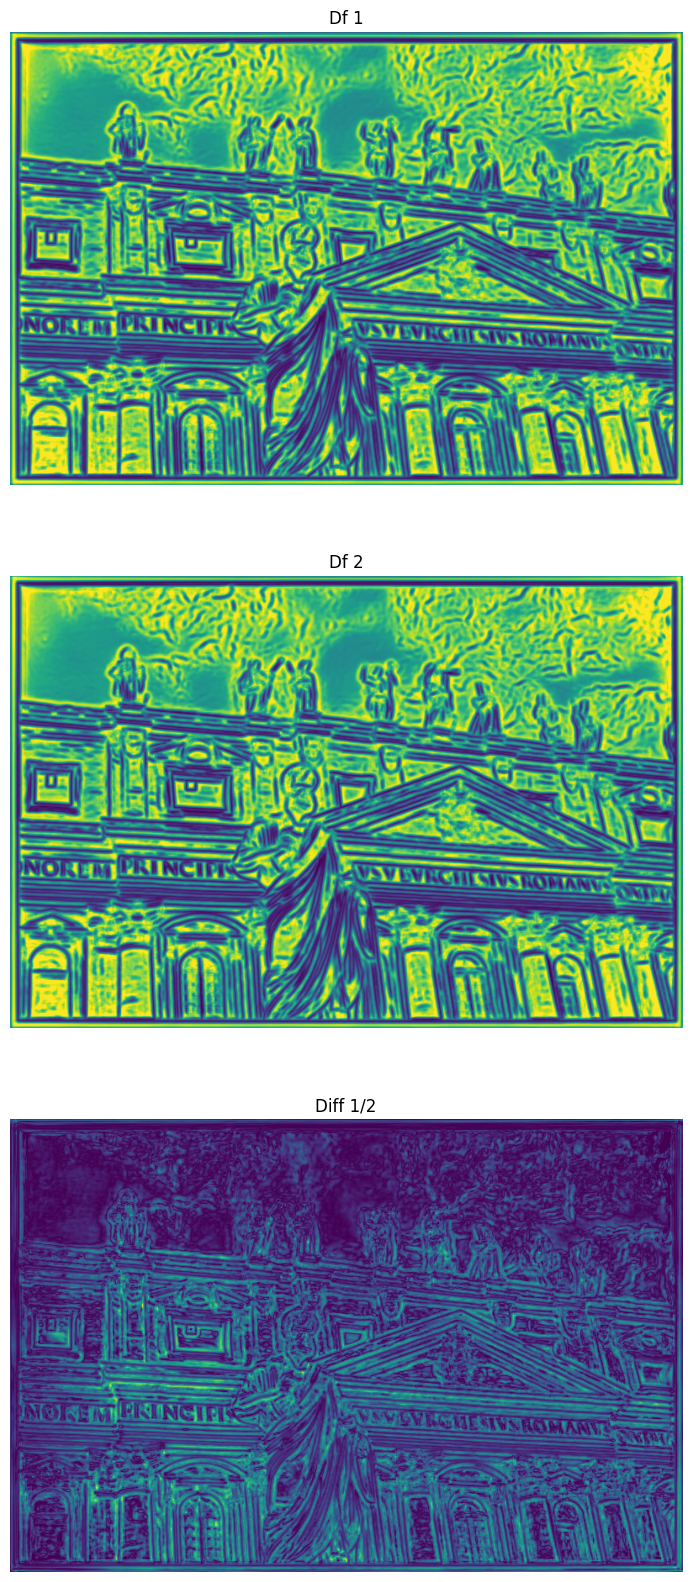

In [29]:
_, ax = plt.subplots(3,1, figsize=(20, 20))
ax[0].axis('off')
ax[0].set_title('Df 1')
ax[0].imshow(df_1)

ax[1].axis('off')
ax[1].set_title('Df 2')
ax[1].imshow(df_1)

ax[2].axis('off')
ax[2].set_title('Diff 1/2')
ax[2].imshow(diff)